# Sentiment Analysis for Prescribed Fire Case 

this notebook will modify a sentiment analysis model to account for political leaning comments, relavant comments, etc. 

--------

In [1]:
import re
import numpy as np
import math
import spacy 
import ftfy
import contractions
from ekphrasis.classes.preprocessor import TextPreProcessor 
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
import pandas as pd
import torch
import matplotlib.pyplot as plt

class prescribedFireSentiment():

    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        
        return 

    # seperates words and makes them lower case, returns list 
    def tokenize(self,text_array):

        # call remove text function first
        clean_text = self.remove_text(text_array)
        token_list = []

        # tokenize string, and remove any empty strings (blank spaces)
        for text in clean_text:
            tokens = [token.text for token in self.nlp(text.strip()) if token.text.strip()]
            token_list.append(tokens)
        
        return token_list

    def len_tokens(self, token_array):
        len_array = []

        for i in token_array:
            len_array.append(len(i))

        return len_array

    # removes urls, special characters, etc... returns cleaner text 
    def remove_text(self,text_array):
        clean_text = []

        for text in text_array:
            text = ftfy.fix_text(text)
            text = re.sub(r"http\S+|www\S+", "", text).strip()  # remove url
            text = re.sub(r"@[A-Za-z0-9_]+", "", text).strip()  # remove mentions
            text = re.sub(r"#", "", text).strip()
            text = re.sub(r"\[removed]|\[deleted]", "", text)
            text = contractions.fix(text)
            clean_text.append(text)
        
        return clean_text

    # calc mean and median of our text input lengths to help see what truncation value we should set.
    # returns mean and median
    def calc_stats(self, text_array):
        total = 0
        median_index = int(len(text_array) / 2)
        for i in text_array:
            total += len(i)

        mean = total / len(text_array)
        median = len(text_array[median_index])

        print("mean: ", mean)
        print("median: ", median)

        return

    # Takes in pandas dataframe and converts to array
    # returns normal array
    def convert_col_to_array(self, df):
        column_name = input("Provide column name: ")

        if column_name in df:
            return list(df[column_name])

        else:
            print("Column Name not found in dataframe")

        return 

    def plot_hist_len(self,len_array):
        data = len_array

        plt.hist(data, bins=len(len_array), color='blue', alpha=0.7)
        plt.title('Histogram')
        plt.xlabel('Length of Row')
        plt.ylabel('Frequency')
        plt.show()

    # creates model from roberta-base. The documentation is on Hugging Face. 
    # returns sentiment scores for given text. 
    def score(self,text):
        MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
        config = AutoConfig.from_pretrained(MODEL)
        model = AutoModelForSequenceClassification.from_pretrained(MODEL)

        text = text
        text = self.remove_text(text)

        tokenizer = AutoTokenizer.from_pretrained(MODEL)
        encoded_input = tokenizer(text, return_tensors='pt')
        
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)   
        
        return scores

    def train_roberta_model(self,model,MODEL,csv_data):

        df = pd.read_csv(csv_data)

        y_cols = df.loc[0:len(df),("frustration", "political", "Talks about solution")]
        x_cols = list(df["text"])
        
        # clean the text
        x_cols = self.remove_text(x_cols)

        tokenizer = AutoTokenizer.from_pretrained(MODEL)

        x_cols = tokenizer(x_cols, padding=True, truncation=True, max_length=20, return_tensors='pt')
    
        # x_data = torch.tensor(x_cols)

        return x_cols


In [2]:
df = pd.read_csv("losAngelesDataReplies.csv")
df

,text,date,frustration,political,offers a solution,spreads news,fear or panic,blame,humurous,sarcastic,grateful,seeking help
0,This is on us. One of us should have remembere...,1/25/25,1,0,0,0,0,0,0,1,0,0
1,"It’s that easy, huh?",1/25/25,0,0,0,0,0,0,0,1,0,0
2,"I have to say--the city, the office of emergen...",1/13/25,0,0,0,0,0,0,0,0,1,0
3,"The Kardashians reside in Calabasas, Californi...",1/13/25,0,1,0,0,0,0,0,0,0,0
4,"I was evacuated, applied Sunday and got approv...",1/14/25,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
196,Thanks for commenting. I pulled the data from ...,1/15/25,0,0,0,1,0,0,0,0,0,0
197,"So far, the KCAL Plus is available only via OT...",1/10/25,0,0,0,1,0,0,0,0,0,0
198,The people in this video are donating all of t...,1/13/25,1,0,0,0,0,1,0,0,0,0
199,Not me you idiots. The person in the video an...,1/13/25,1,0,0,0,0,1,0,0,0,0


{'frustration': 40, 'political': 22, 'offers a solution': 13, 'spreads news': 53, 'fear or panic': 2, 'blame': 26, 'humurous': 5, 'sarcastic': 11, 'grateful': 28, 'seeking help': 11}


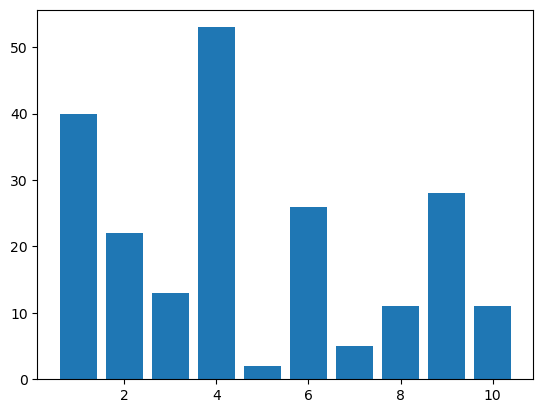

In [3]:
# For right now, I want to see the distrubution of labels that I have present in my training data. 

sentiment_model = prescribedFireSentiment()

x_data = list(df["text"])
y_data = df[["frustration", "political","offers a solution", "spreads news", 
             "fear or panic", "blame", "humurous", "sarcastic", "grateful", "seeking help"]]

y_count = {}

for column in y_data:
    if column not in y_count:
        y_count[column] = 0
        
    for i in y_data[column]:
        if i == 1:
            y_count[column] += 1 

x_line = np.linspace(1,10,10)
print(y_count)
plt.bar(x_line,y_count.values());

In [4]:
example = "Joey really loves his bike!! @Billy214 check this out!! Don't worry, can't try! www.wowza.com #baller"
example_2 = "[deleted]"
model = prescribedFireSentiment()

In [5]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
config = AutoConfig.from_pretrained(MODEL)
pretrained_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
df = pd.read_csv("LosAngelesDataTitles.csv")
array = model.convert_col_to_array(df)
token_array = model.tokenize(array)
model.calc_stats(token_array)

Provide column name:  text


mean:  14.757961783439491
median:  8


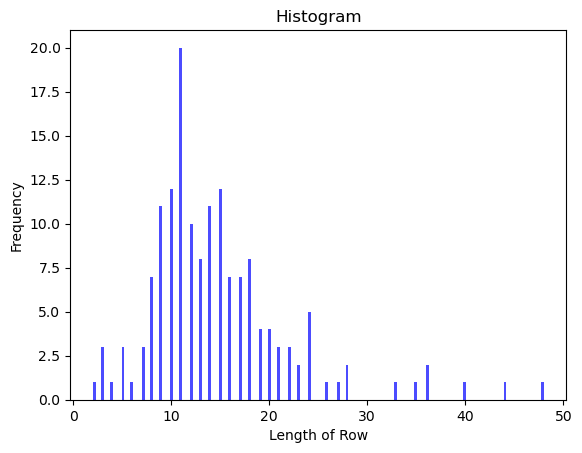

In [7]:
len_array = model.len_tokens(token_array)
model.plot_hist_len(len_array)

In [8]:
model.train_roberta_model(model = pretrained_model, MODEL=MODEL, csv_data = "LosAngelesDataTitles.csv")

{'input_ids': tensor([[    0, 24485,  1422,  ...,     1,     1,     1],
        [    0, 30408,  4082,  ...,  3129,  2306,     2],
        [    0,  6517, 15478,  ...,     1,     1,     1],
        ...,
        [    0, 38195,  2752,  ...,     1,     1,     1],
        [    0, 30909, 23668,  ...,     1,     1,     1],
        [    0, 30909,  7051,  ...,     2,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0]])}

In [244]:
# notes
# --------------------------
# labels need to be properly formatted 
# Use multi-label-classification
# freeze and unfreeze layers 
# Find good optimizer and learning rate 
# Train and validate with kaggle data 
# start testing on my reddit data 

In [ ]:
# next time, I need to use a kaggle dataset and modify it to contain the labels I need. Use binary.
# First, I need to train on general data to help my model understand pos/neg/neutral. Finally getting some momentum!!

In [28]:
import pandas as pd

# Time to clean my training data for wha

train_data = pd.read_csv("tweets.csv")
train_data

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [29]:
# Convert my sentiment values from string to bit value [positive,negative,neutral]

def convert_sentiment(data):
    train_data = data
    count = 0
    for i in train_data["sentiment"]:
        if i == "positive":
            train_data.loc[count, "sentiment"] = [1,0,0]
        elif i == "negative":
            train_data.loc[count, "sentiment"] = [0,1,0]
        elif i == "neutral":
            train_data.loc[count, "sentiment"] = [0,0,1]
        else:
            train_data.loc[count, "sentiment"] = [0,0,0]

        count += 1

    return train_data

new_train = convert_sentiment(train_data)

In [30]:
new_train

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going","[0, 0, 1]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,"[0, 1, 0]"
2,088c60f138,my boss is bullying me...,bullying me,"[0, 1, 0]"
3,9642c003ef,what interview! leave me alone,leave me alone,"[0, 1, 0]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,","[0, 1, 0]"
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,"[0, 1, 0]"
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force","[0, 1, 0]"
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,"[1, 0, 0]"
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,"[1, 0, 0]"
